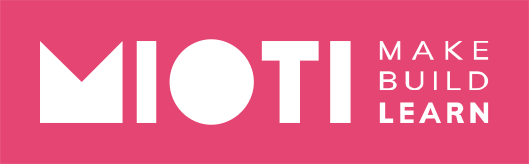
<center style="color:#888">Estadística para Data Science<br/>Asignatura Estadística</center>

# EJERCICIO TRABAJO GRUPO: "MANOVA"


Los alumnos, por grupo, deberán entregar, una challenge por cada grupo:
- SESION 8 - EJERCICIOS TRABAJO EN EQUIPO - MANOVA - GRUPOXX
- donde XX es el nombre/núero  del equipo/grupo.
- Se usará para su resolución Python.
<hr>

*Nombre Equipo*: PYTHONEROS

Miembros del equipo: Pablo Sagrera / Efrain Gonzalez
>> 

<hr>

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

# Estudio Preliminar

##### El test de **ANOVA** es una manera de encontrar si los resultados de un experimento son significativos.

##### Es decir, nos ayuda a descrubir si tenemos que rechazar la hipotesis nula o aceptar la hipotesis alternativa

##### Basicamente comprobamos si hay diferencias entre los grupos que estamos estudiando: 

+ Ejemplo:
	- Un grupo de pacientes estan probando 3 terapias diferentes: Quieres saber si una es mejor que las otras.
	- Estudiantes de diferentes colegios hacen el mismo examen. Quires ver que colegio consigue mejores resultados.


##### El **ANOVA** parte de algunos supuestos o hipótesis que han de cumplirse:

		- La variable dependiente debe medirse al menos a nivel de intervalo.
		- Independencia de las observaciones.
		- La distribución de los residuales debe ser normal.
		- Homocedasticidad: homogeneidad de las varianzas.



##### En estadística el análisis multivariante de la varianza o **MANOVA** (por su nombre en inglés, Multivariate analysis of variance) es una extensión del análisis de la varianza o ANOVA para cubrir los casos donde hay más de una variable dependiente que no pueden ser combinadas de manera simple.

##### Además de identificar si los cambios en las variables independientes tienen efectos significativos en las variables 
##### dependientes, la técnica también intenta identificar las interacciones entre las variables independientes y su grado de  
##### asociación con las dependientes.

##### Con este test tratamos de responder a preguntas como : 

    - ¿Los cambios en las variables independientes tienen efectos estadísticos significativos en la variable dependiente?
    - Cuales son las interacciones entre las variables dependientes ?
    - Cuales son las interacciones entre las variables independientes ? 


# DETALLE
<hr>

In [2]:
## Cargamos los datos y echamos un vistazo
df = pd.read_csv('iris.csv',index_col=0)
df.columns = df.columns.str.replace(".", "_") 
df.head(15)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa
10,4.9,3.1,1.5,0.1,setosa


In [3]:
print('Cantidad de Filas y columnas:',df.shape)
print('Nombre columnas:',df.columns)

Cantidad de Filas y columnas: (150, 5)
Nombre columnas: Index(['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width',
       'Species'],
      dtype='object')


In [4]:
print(df.groupby('Species').size())

Species
setosa        50
versicolor    50
virginica     50
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal_Length  150 non-null    float64
 1   Sepal_Width   150 non-null    float64
 2   Petal_Length  150 non-null    float64
 3   Petal_Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [6]:
df.describe()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 1- TEST ANOVA 

### 1.1 - ANOVA con una característica categórica

##### Estas tres especies se pueden considerar distintas entre ellas estadisticamente en relacion a la longitud de los petalos ? 


La hipótesis a contrastar sería 

$$ 
\begin{cases}
H_0: & \mu_1 = \mu_2 = \dots = \mu_k \\
H_1: & \mbox{ al menos una es distinta }
\end{cases}
$$

##### Consideraremos un factor $F$ (especie) que puede presentarse bajo un cierto número de niveles ( setosa, versicolor etc.) y que actúa sobre una variable respuesta $X$ (longitud del sepalo). El modelo que consideraremos será:

$$x_{ij} = \mu_j + e_{ij} \qquad e_{ij} \sim \mathcal{N}(0, \sigma)$$

Donde 

* $x_{ij}$ es la observación j-ésima correspondiente al nivel i-ésimo del factor.
* $\mu_i$ es una constante común a todas las observaciones correspondientes al nivel $i$ del factor. 
* $e_{ij}$ es la parte de la variable observada que no queda expliada por el factor $F$ (error experimental).

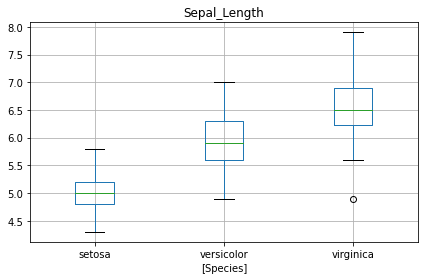

In [7]:
# Realizamos un diagrama de cajas para tener una vision rapida de las medias de las 3 especies
df_tmp = df.copy()
df_tmp = df_tmp[['Sepal_Length','Species']]
df_tmp.boxplot(by="Species")
plt.suptitle('')
plt.tight_layout()
plt.show()

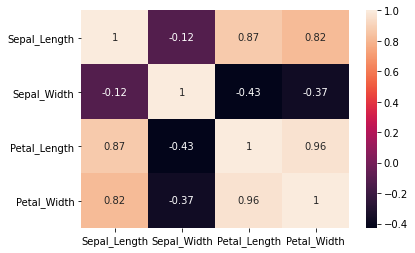

In [25]:
## Matriz de correlacion
sns.heatmap(df.corr(),  annot=True)

In [18]:
iris_one_categorical=ols('Sepal_Length ~ C(Species)', data=df).fit() #Especificamos C para Categorica
sm.stats.anova_lm(iris_one_categorical, typ=2)

,sum_sq,df,F,PR(>F)
C(Species),63.212133,2.0,119.264502,1.669669e-31
Residual,38.956200,147.0,NaN,NaN


In [19]:
iris_one_categorical.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sepal_Length   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     119.3
Date:                Mon, 11 May 2020   Prob (F-statistic):           1.67e-31
Time:                        11:06:15   Log-Likelihood:                -111.73
No. Observations:                 150   AIC:                             229.5
Df Residuals:                     147   BIC:                             238.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.0060      0.073     68.762      0.000       4.862       5.150
C(Species)[T.versicolor]     0.9300      0.103      9.033      0.000       0.727       1.133
C(Species)[T.virginica]      1.5820      0.103     15.366      0.000       1.379       1.785
==============================================================================
Omnibus:                        1.188   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                0.785
Skew:                           0.119   Prob(JB):                        0.675
Kurtosis:                       3.263   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### - En base a los resultados del test de ANOVA podemos **rechazar la hipotesis nula** dado que el **p-valor** < 0,05, es decir hay diferencias significativas entre alguno de los grupos (especies)

### 2 - ANOVA con una característica categórica y todas las numericas

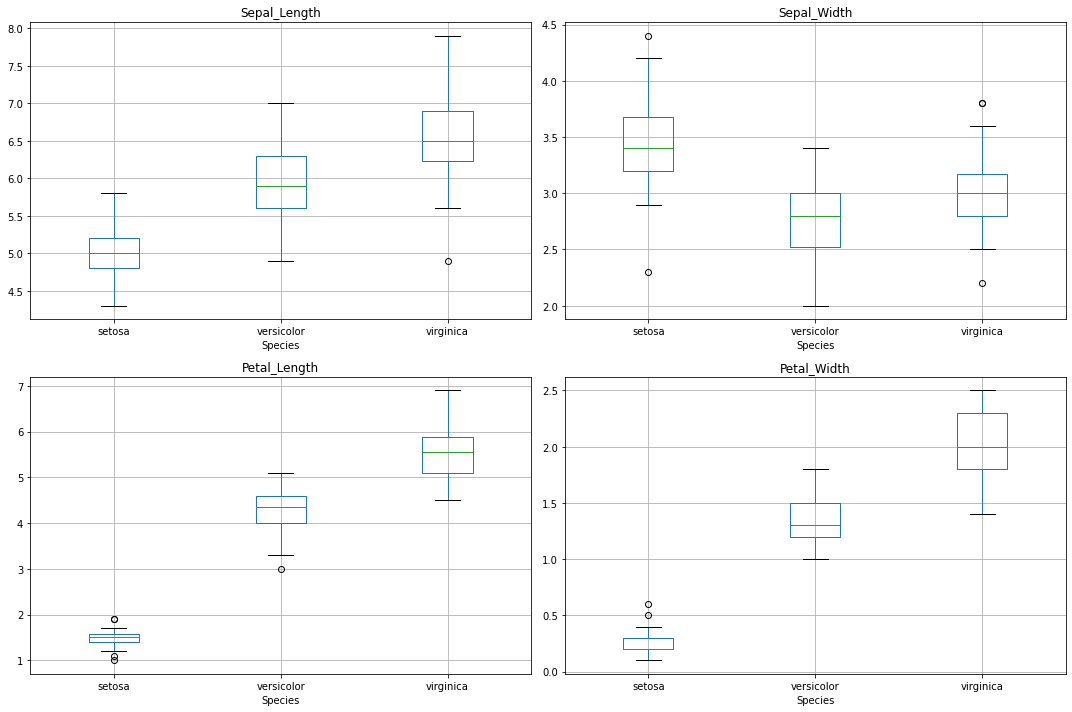

In [11]:
## Realizamos diagramas de cajas para tener una vision general 
fig, axes = plt.subplots(2,2,figsize=(15, 10))
for i,el in enumerate(list(df.columns.values)[:-1]):
    a = df.boxplot(el, by="Species", ax=axes.flatten()[i])

plt.tight_layout() 
plt.suptitle('')
plt.tight_layout()
plt.show()


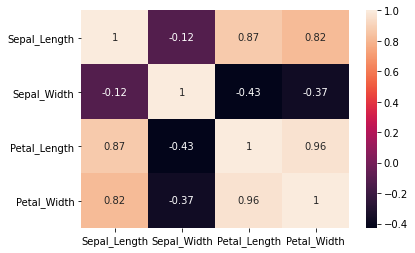

In [24]:
sns.heatmap(df.corr(),  annot=True)

In [13]:
iris_lm=ols('Sepal_Length ~ C(Species) + Sepal_Width + Petal_Length + Petal_Width', data=df).fit() #Especificamos C para Categorica
sm.stats.anova_lm(iris_lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Species),0.888920,2.0,4.721152,1.032884e-02
Sepal_Width,3.125004,1.0,33.194491,4.867516e-08
Petal_Length,13.785343,1.0,146.430978,1.073592e-23
Petal_Width,0.409029,1.0,4.344799,3.888826e-02
Residual,13.556485,144.0,NaN,NaN


In [14]:
iris_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sepal_Length   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     188.3
Date:                Mon, 11 May 2020   Prob (F-statistic):           2.67e-61
Time:                        11:05:35   Log-Likelihood:                -32.558
No. Observations:                 150   AIC:                             77.12
Df Residuals:                     144   BIC:                             95.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.1713      0.280      7.760      0.000       1.618       2.724
C(Species)[T.versicolor]    -0.7236      0.240     -3.013      0.003      -1.198      -0.249
C(Species)[T.virginica]     -1.0235      0.334     -3.067      0.003      -1.683      -0.364
Sepal_Width                  0.4959      0.086      5.761      0.000       0.326       0.666
Petal_Length                 0.8292      0.069     12.101      0.000       0.694       0.965
Petal_Width                 -0.3152      0.151     -2.084      0.039      -0.614      -0.016
==============================================================================
Omnibus:                        0.418   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.572
Skew:                          -0.060   Prob(JB):                        0.751
Kurtosis:                       2.722   Cond. No.                         94.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3- MANOVA


##### En el caso de MANOVA la hipotesis nula sera que los diferentes grupos (**Species**) tienen un centroide comun en el espacio de vectores de variables dependientes (**DV**) y la hipotesis alternativa sera que al menos un grupo (**Species**) tiene un centroide distinto en el espacio de vectores de variables dependientes 

In [15]:
maov = MANOVA.from_formula('Sepal_Length + Sepal_Width + \
                            Petal_Length + Petal_Width  ~ Species', data=df)

Final step is to print the results using *mv_test*:

In [16]:
print(maov.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0170 4.0000 144.0000 2086.7720 0.0000
         Pillai's trace  0.9830 4.0000 144.0000 2086.7720 0.0000
 Hotelling-Lawley trace 57.9659 4.0000 144.0000 2086.7720 0.0000
    Roy's greatest root 57.9659 4.0000 144.0000 2086.7720 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
        Species          Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0234 8.0000 288.0000  199.1453 0.0000
         Pillai's trace  1.1919 8.0000 290.00

##### En MANOVA, Λ comprueba si hay diferencias entre las medias del grupo para una combinación particular de variables dependientes. Es similar a la F estadística de ANOVA. Lambda es una medida de la varianza porcentual en las variables dependientes que no se explica por las diferencias en los niveles de la variable independiente. Un valor de cero significa que no hay ninguna varianza no explicada por la variable independiente (que es ideal). En otras palabras, cuanto más se acerca a cero la estadística, más contribuye la variable en cuestión al modelo. Se rechazaría la hipótesis nula cuando la lambda de Wilk está cerca de cero, aunque esto debería hacerse en combinación con un valor pequeño de p. Luego en este caso rechazamos la hipotesis nula de que los diferentes grupos (Species) tienen un centroide comun en el espacio de vectores de variables dependientes (DV)

###### Fuente : http://userwww.sfsu.edu/efc/classes/biol710/manova/manovanewest.htm